In [1]:
# ==============================================================================
# CELL 1: Data Loading and Setup
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['recsys_db']
reviews_collection = db['Clothing_Shoes_and_Jewelry']
meta_collection = db['meta_Clothing_Shoes_and_Jewelry']

# Fetch a random sample of 100,000 reviews
print("Fetching a random sample of 100,000 reviews...")
pipeline = [{'$sample': {'size': 100000}}]
cursor = reviews_collection.aggregate(pipeline, allowDiskUse=True)

# Load in chunks to manage memory
batch_size = 10000
batches = []
batch = []

for i, doc in enumerate(cursor, start=1):
    batch.append(doc)
    if i % batch_size == 0:
        batches.append(pd.DataFrame(batch))
        print(f"Loaded {i} documents so far...")
        batch = []

if batch:
    batches.append(pd.DataFrame(batch))

# Concatenate all batches
reviews_df = pd.concat(batches, ignore_index=True)
print(f"✅ Successfully loaded {len(reviews_df)} reviews into DataFrame")

Fetching a random sample of 100,000 reviews...
Loaded 10000 documents so far...
Loaded 20000 documents so far...
Loaded 30000 documents so far...
Loaded 40000 documents so far...
Loaded 50000 documents so far...
Loaded 60000 documents so far...
Loaded 70000 documents so far...
Loaded 80000 documents so far...
Loaded 90000 documents so far...
Loaded 100000 documents so far...
✅ Successfully loaded 100000 reviews into DataFrame


In [2]:
# ==============================================================================
# CELL 2: Load and Merge Product Metadata
# ==============================================================================

# Get unique parent ASINs from reviews
parent_asins_in_sample = reviews_df['parent_asin'].unique().tolist()

# Fetch metadata for these products
print(f"Fetching metadata for {len(parent_asins_in_sample)} unique parent products...")
meta_docs = list(meta_collection.find({'parent_asin': {'$in': parent_asins_in_sample}}))

# Convert to DataFrame
meta_df = pd.DataFrame(meta_docs)
print(f"Successfully loaded metadata for {len(meta_df)} products")

# Merge reviews with metadata on parent_asin
if not meta_df.empty:
    print("Merging reviews with product metadata...")
    merged_df = pd.merge(
        reviews_df,
        meta_df,
        on='parent_asin',
        how='inner',
        suffixes=('_review', '_meta')
    )
    print(f"✅ Successfully merged data. Final dataset: {len(merged_df)} reviews")
    print(f"Unique users: {merged_df['user_id'].nunique()}")
    print(f"Unique products: {merged_df['parent_asin'].nunique()}")
else:
    print("❌ Could not perform merge - no matching metadata found")

Fetching metadata for 75084 unique parent products...
Successfully loaded metadata for 75084 products
Merging reviews with product metadata...
✅ Successfully merged data. Final dataset: 100000 reviews
Unique users: 98186
Unique products: 75084


In [3]:
# ==============================================================================
# CELL 3: Create User Taste Profiles and Clustering
# ==============================================================================

# Explode categories to create one row per user-category interaction
print("Creating user taste profiles from product categories...")
exploded_df = merged_df.explode('categories')
print(f"✅ DataFrame exploded by category: {len(exploded_df)} rows")

# Count reviews per user per category
user_category_counts = exploded_df.groupby(['user_id', 'categories']).size().reset_index(name='review_count')
print("✅ User-category counts calculated")

# Pivot to create user taste vectors (users × categories matrix)
user_taste_df = user_category_counts.pivot_table(
    index='user_id',
    columns='categories',
    values='review_count',
    fill_value=0
)

print(f"✅ User taste profile created")
print(f"Shape: {user_taste_df.shape} (users × categories)")
print(f"Categories available: {user_taste_df.shape[1]}")

# Standardize the taste vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_taste_df)
print("✅ User taste data standardized")

# Find optimal number of clusters using silhouette analysis
print("\nFinding optimal number of clusters...")
k_range = range(2, 11)
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: silhouette={silhouette_avg:.3f}, inertia={kmeans.inertia_:.0f}")

# Select best k based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Best k based on silhouette score: {best_k}")

# Final clustering with best k
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)
user_taste_df['cluster'] = cluster_labels

print(f"✅ Successfully clustered {len(user_taste_df)} users into {best_k} groups")
print("\nCluster distribution:")
print(user_taste_df['cluster'].value_counts().sort_index())

Creating user taste profiles from product categories...
✅ DataFrame exploded by category: 487476 rows
✅ User-category counts calculated
✅ User taste profile created
Shape: (98186, 958) (users × categories)
Categories available: 958
✅ User taste data standardized

Finding optimal number of clusters...
k=2: silhouette=0.122, inertia=93719537
k=3: silhouette=-0.075, inertia=93662018


KeyboardInterrupt: 

In [7]:
#  ==============================================================================
# MEMORY-SAFE VERSION - Cell 3: Create User Taste Profiles
# ==============================================================================

import psutil
import gc

def check_memory():
    """Check current memory usage"""
    memory = psutil.virtual_memory()
    print(f"Memory usage: {memory.percent:.1f}% ({memory.used/1e9:.1f}GB / {memory.total/1e9:.1f}GB)")
    return memory.percent

def safe_explode_categories(merged_df, max_memory_percent=80):
    """Safely explode categories with memory monitoring"""
    print("Starting category explosion with memory monitoring...")
    check_memory()
    
    # Check data size first
    print(f"Input data: {len(merged_df)} rows, {merged_df['user_id'].nunique()} users")
    
    # Filter to users with reasonable activity first (prevents explosion)
    user_activity = merged_df['user_id'].value_counts()
    print(f"User activity stats:")
    print(f"  Mean reviews per user: {user_activity.mean():.1f}")
    print(f"  Median reviews per user: {user_activity.median():.1f}")
    print(f"  Max reviews per user: {user_activity.max()}")
    
    # Filter out super active users that might cause memory issues
    reasonable_users = user_activity[user_activity <= 50].index  # Max 50 reviews per user
    filtered_df = merged_df[merged_df['user_id'].isin(reasonable_users)]
    print(f"After filtering: {len(filtered_df)} rows, {filtered_df['user_id'].nunique()} users")
    
    check_memory()
    
    # Now explode
    exploded_df = filtered_df.explode('categories')
    print(f"After explosion: {len(exploded_df)} rows")
    
    check_memory()
    if check_memory() > max_memory_percent:
        print("⚠️ High memory usage detected!")
        return None
    
    return exploded_df

def create_user_taste_sample(exploded_df, sample_users=5000):
    """Create taste profiles for a sample of users"""
    print(f"Creating taste profiles for sample of {sample_users} users...")
    
    # Sample users randomly
    unique_users = exploded_df['user_id'].unique()
    if len(unique_users) > sample_users:
        sampled_users = np.random.choice(unique_users, size=sample_users, replace=False)
        exploded_sample = exploded_df[exploded_df['user_id'].isin(sampled_users)]
        print(f"Sampled {len(sampled_users)} users, {len(exploded_sample)} rows")
    else:
        exploded_sample = exploded_df
        print(f"Using all {len(unique_users)} users")
    
    check_memory()
    
    # Count reviews per user per category
    user_category_counts = exploded_sample.groupby(['user_id', 'categories']).size().reset_index(name='review_count')
    print(f"User-category combinations: {len(user_category_counts)}")
    
    check_memory()
    
    return user_category_counts

# Start the safe process
print("="*60)
print("STARTING MEMORY-SAFE TASTE-BASED CLUSTERING")
print("="*60)

# Check initial memory
initial_memory = check_memory()
if initial_memory > 70:
    print("⚠️ Warning: Starting with high memory usage!")

# Step 1: Safe category explosion
exploded_df = safe_explode_categories(merged_df, max_memory_percent=85)

if exploded_df is None:
    print("❌ Memory limit reached during explosion. Try with smaller dataset.")
else:
    print("✅ Category explosion successful")
    
    # Clean up
    gc.collect()
    
    # Step 2: Create user-category counts for sample
    user_category_counts = create_user_taste_sample(exploded_df, sample_users=3000)
    
    # Step 3: Create taste matrix (the dangerous part)
    print("\nCreating user taste matrix...")
    check_memory()
    
    try:
        user_taste_df = user_category_counts.pivot_table(
            index='user_id',
            columns='categories', 
            values='review_count',
            fill_value=0
        )
        print(f"✅ Taste matrix created: {user_taste_df.shape}")
        check_memory()
        
        # Check if matrix is reasonable size
        matrix_size_mb = user_taste_df.memory_usage(deep=True).sum() / 1e6
        print(f"Matrix size: {matrix_size_mb:.1f} MB")
        
        if matrix_size_mb > 500:  # More than 500MB
            print("⚠️ Matrix is large, consider further sampling")
        
        print("\n✅ Ready for clustering!")
        print(f"Users: {user_taste_df.shape[0]}")
        print(f"Categories: {user_taste_df.shape[1]}")
        
    except MemoryError:
        print("❌ Out of memory creating taste matrix!")
        print("Try reducing sample_users or filtering categories")

print(f"\nFinal memory check:")
check_memory()

STARTING MEMORY-SAFE TASTE-BASED CLUSTERING
Memory usage: 73.0% (11.1GB / 16.2GB)
⚠️ Warning: Starting with high memory usage!
Starting category explosion with memory monitoring...
Memory usage: 73.0% (11.1GB / 16.2GB)
Input data: 100000 rows, 98186 users
User activity stats:
  Mean reviews per user: 1.0
  Median reviews per user: 1.0
  Max reviews per user: 21
After filtering: 100000 rows, 98186 users
Memory usage: 73.3% (11.2GB / 16.2GB)
After explosion: 487476 rows
Memory usage: 74.3% (11.3GB / 16.2GB)
Memory usage: 74.3% (11.3GB / 16.2GB)
✅ Category explosion successful
Creating taste profiles for sample of 3000 users...
Sampled 3000 users, 14843 rows
Memory usage: 73.4% (11.2GB / 16.2GB)
User-category combinations: 14747
Memory usage: 73.4% (11.2GB / 16.2GB)

Creating user taste matrix...
Memory usage: 73.4% (11.2GB / 16.2GB)
✅ Taste matrix created: (3000, 523)
Memory usage: 73.4% (11.2GB / 16.2GB)
Matrix size: 12.8 MB

✅ Ready for clustering!
Users: 3000
Categories: 523

Final me

73.4

Starting clustering on 3000 users with 523 categories
Standardizing data...
✅ Data standardized

Quick k-value testing...
k=3: inertia=1555773
k=4: inertia=1543892
k=5: inertia=1541173
k=6: inertia=1534261
k=7: inertia=1533592

Inertia reductions (looking for elbow):
k=3→4: 0.8% reduction
k=4→5: 0.2% reduction
k=5→6: 0.4% reduction
k=6→7: 0.0% reduction

--- Running final clustering with k=5 ---
✅ Clustering complete!
Silhouette score: -0.144
Final inertia: 1541173

Cluster distribution:
  Cluster 0:  229 users ( 7.6%)
  Cluster 1:   63 users ( 2.1%)
  Cluster 2: 2547 users (84.9%)
  Cluster 3:   54 users ( 1.8%)
  Cluster 4:  107 users ( 3.6%)

CLUSTER TASTE PROFILES

--- Cluster 0 (229 users, 7.6%) ---
Top categories (standardized scores):
  • Novelty: 2.657
  • Novelty & More: 2.616
  • T-Shirts: 2.513
  • Shirts: 1.964
  • Tops & Tees: 1.182
  • Clothing: 1.153
  • Casual Button-Down Shirts: 0.767
  • Hoodies: 0.700
  • Polos: 0.548
  • Active Shirts & Tees: 0.506

--- Cluster 1 (6

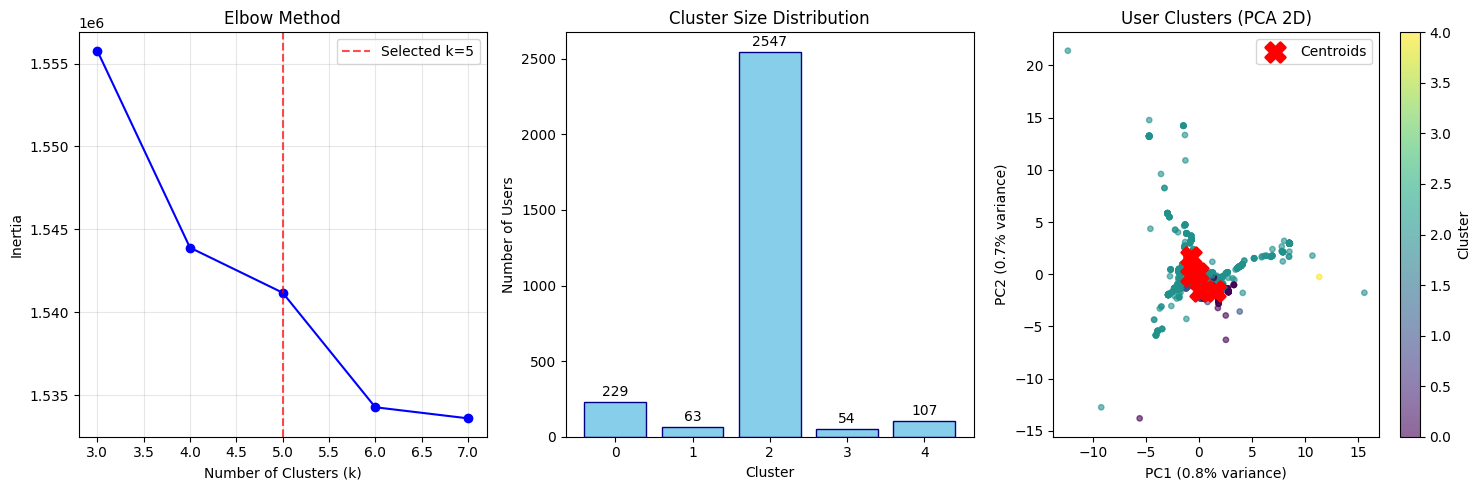


✅ Taste-based user segmentation complete!
You now have 5 distinct user segments based on product category preferences.
Total variance explained by first 2 PCs: 1.5%

--- Sample Users by Cluster ---

Cluster 0 example user (AEK2ALFYZAUK3EU5UTYD5YRJ4QEA):
  • Clothing: 1 reviews
  • Clothing, Shoes & Jewelry: 1 reviews
  • Dresses: 1 reviews
  • Novelty: 1 reviews
  • Novelty & More: 1 reviews

Cluster 1 example user (AHMHF6MJWL77SPJIIE53D6TO4WOA):
  • Baby: 1 reviews
  • Baby Girls: 1 reviews
  • Clothing: 1 reviews
  • Clothing, Shoes & Jewelry: 1 reviews
  • Dresses: 1 reviews

Cluster 2 example user (AFUD2G3ZWK4KRS7MUNBRIEPDJT6A):
  • Clothing, Shoes & Jewelry: 1 reviews
  • Jewelry Accessories: 1 reviews
  • Jewelry Armoires: 1 reviews
  • Jewelry Boxes & Organizers: 1 reviews
  • Shoe, Jewelry & Watch Accessories: 1 reviews

Cluster 3 example user (AH4PTWZ3EVDLVRDM565UTS5TU4XA):
  • Clothing, Shoes & Jewelry: 1 reviews
  • Jewelry: 1 reviews
  • Necklaces: 1 reviews
  • Pendant Ne

In [8]:
# ==============================================================================
# CLUSTERING YOUR 3K USER SAMPLE
# ==============================================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Your user_taste_df is ready: (3000, 523)
print(f"Starting clustering on {user_taste_df.shape[0]} users with {user_taste_df.shape[1]} categories")

# Standardize the taste vectors
print("Standardizing data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_taste_df)
print("✅ Data standardized")

# Test a few k values quickly (using inertia, not silhouette)
print("\nQuick k-value testing...")
k_values = [3, 4, 5, 6, 7]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia = kmeans.inertia_
    results.append((k, inertia))
    print(f"k={k}: inertia={inertia:.0f}")

# Calculate inertia reductions to find elbow
print("\nInertia reductions (looking for elbow):")
for i in range(1, len(results)):
    k_prev, inertia_prev = results[i-1]
    k_curr, inertia_curr = results[i]
    reduction = (inertia_prev - inertia_curr) / inertia_prev * 100
    print(f"k={k_prev}→{k_curr}: {reduction:.1f}% reduction")

# Choose k=5 as reasonable default (you can change this)
best_k = 5
print(f"\n--- Running final clustering with k={best_k} ---")

final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)
user_taste_df['cluster'] = cluster_labels

# Calculate silhouette score for chosen k
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f"✅ Clustering complete!")
print(f"Silhouette score: {silhouette_avg:.3f}")
print(f"Final inertia: {final_kmeans.inertia_:.0f}")

print(f"\nCluster distribution:")
cluster_counts = user_taste_df['cluster'].value_counts().sort_index()
for i, count in cluster_counts.items():
    pct = count / len(user_taste_df) * 100
    print(f"  Cluster {i}: {count:4d} users ({pct:4.1f}%)")

# ==============================================================================
# ANALYZE CLUSTER TASTE PROFILES
# ==============================================================================

print("\n" + "="*60)
print("CLUSTER TASTE PROFILES")
print("="*60)

# Get cluster centroids
centroids_df = pd.DataFrame(
    final_kmeans.cluster_centers_,
    columns=user_taste_df.columns[:-1],  # exclude 'cluster' column
    index=[f'Cluster {i}' for i in range(best_k)]
)

# Analyze each cluster's preferences
for i in range(best_k):
    cluster_size = cluster_counts[i]
    print(f"\n--- Cluster {i} ({cluster_size} users, {cluster_size/len(user_taste_df)*100:.1f}%) ---")
    
    cluster_profile = centroids_df.iloc[i].sort_values(ascending=False)
    top_categories = cluster_profile.head(10)
    
    print("Top categories (standardized scores):")
    for category, score in top_categories.items():
        if score > 0.1:  # Only show meaningful scores
            print(f"  • {category}: {score:.3f}")
        elif score > 0.05:
            print(f"    {category}: {score:.3f}")

# ==============================================================================
# VISUALIZATION
# ==============================================================================

print(f"\nCreating visualizations...")

# 1. Inertia plot (elbow method)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
k_vals, inertias = zip(*results)
plt.plot(k_vals, inertias, 'bo-')
plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.7, label=f'Selected k={best_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Cluster size distribution
plt.subplot(1, 3, 2)
cluster_sizes = [cluster_counts[i] for i in range(best_k)]
plt.bar(range(best_k), cluster_sizes, color='skyblue', edgecolor='navy')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Cluster Size Distribution')
for i, size in enumerate(cluster_sizes):
    plt.text(i, size + 20, str(size), ha='center', va='bottom')

# 3. PCA 2D visualization
plt.subplot(1, 3, 3)
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(X_scaled)

scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6, s=15)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('User Clusters (PCA 2D)')
plt.colorbar(scatter, label='Cluster')

# Add cluster centers
pca_centers = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], 
           c='red', marker='X', s=200, linewidths=2, label='Centroids')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Taste-based user segmentation complete!")
print(f"You now have {best_k} distinct user segments based on product category preferences.")
print(f"Total variance explained by first 2 PCs: {sum(pca.explained_variance_ratio_):.1%}")

# Show a few example users from each cluster
print(f"\n--- Sample Users by Cluster ---")
for i in range(best_k):
    cluster_users = user_taste_df[user_taste_df['cluster'] == i]
    sample_user = cluster_users.sample(1).index[0]
    user_categories = cluster_users.loc[sample_user].drop('cluster')
    active_categories = user_categories[user_categories > 0].sort_values(ascending=False).head(5)
    
    print(f"\nCluster {i} example user ({sample_user}):")
    for cat, count in active_categories.items():
        print(f"  • {cat}: {int(count)} reviews")

Preparing product metadata for clustering...
✅ Text data prepared for 75084 products.

Vectorizing product text with TF-IDF...
✅ TF-IDF matrix created with shape: (75084, 3000)

Finding optimal number of product clusters (k)...
  k=10, inertia=67928.51
  k=20, inertia=65555.05
  k=30, inertia=63874.12
  k=40, inertia=62726.71
  k=50, inertia=61626.13
  k=60, inertia=60916.74
  k=70, inertia=60232.00
  k=80, inertia=59640.11
  k=90, inertia=59174.19
  k=100, inertia=58621.40


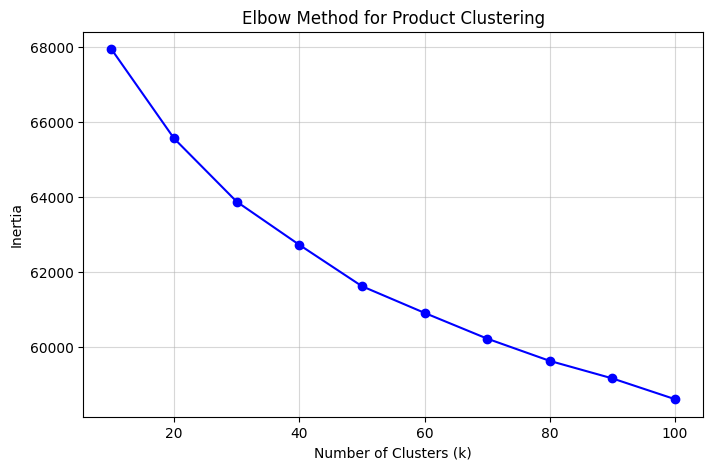


Running final product clustering with k=50...
✅ Products clustered into 50 buckets.

Product cluster distribution:
                 count
product_cluster       
0                 5867
1                 6312
2                 1426
3                 1036
4                 3765
5                 2165
6                 1200
7                 1090
8                 2173
9                  296
10                1446
11                1571
12                3510
13                1681
14                 784
15                1362
16                1510
17                 783
18                 874
19                1305
20                1306
21                2463
22                 600
23                1992
24                1420
25                1155
26                2734
27                 906
28                1480
29                 923
30                1051
31                 538
32                1157
33                 276
34                1136
35                1185
36        

In [12]:
# ============================================================
# STAGE 1: PRODUCT CLUSTERING
# ============================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

# --- 1. Prepare Text Data for Products ---
print("Preparing product metadata for clustering...")

# It's safer to work on a copy
meta_df_copy = meta_df.copy()

# Fill missing values and ensure text fields are strings
meta_df_copy['title'] = meta_df_copy['title'].fillna('')
meta_df_copy['description'] = meta_df_copy['description'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else ''
)
meta_df_copy['features'] = meta_df_copy['features'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else ''
)

# Combine text fields into a single document per product
meta_df_copy['combined_text'] = (
    meta_df_copy['title'] + ' ' + 
    meta_df_copy['description'] + ' ' + 
    meta_df_copy['features']
)

print(f"✅ Text data prepared for {len(meta_df_copy)} products.")

# --- 2. Vectorize Text Data with TF-IDF ---
print("\nVectorizing product text with TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=3000,          # Focus on the 3000 most common terms
    stop_words='english',       # Remove common English words
    min_df=5,                   # Ignore rare terms
    max_df=0.7                  # Ignore overly common terms
)

X_tfidf = vectorizer.fit_transform(meta_df_copy['combined_text'])
print(f"✅ TF-IDF matrix created with shape: {X_tfidf.shape}")

# --- 3. Find Optimal Number of Product Clusters (Elbow Method) ---
print("\nFinding optimal number of product clusters (k)...")

inertias = []
k_range = range(10, 101, 10)  # Test k from 10 to 100

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)
    print(f"  k={k}, inertia={kmeans.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Product Clustering')
plt.grid(True, alpha=0.5)
plt.show()

# --- 4. Perform Final Product Clustering ---
best_k_products = 50  # Adjust based on elbow curve
print(f"\nRunning final product clustering with k={best_k_products}...")

product_kmeans = KMeans(n_clusters=best_k_products, random_state=42, n_init=10)
meta_df_copy['product_cluster'] = product_kmeans.fit_predict(X_tfidf)

print(f"✅ Products clustered into {best_k_products} buckets.")
print("\nProduct cluster distribution:")
print(meta_df_copy['product_cluster'].value_counts().sort_index().to_frame())

# --- 5. Inspect Product Clusters ---
print("\n--- Top Keywords per Product Cluster ---")

terms = vectorizer.get_feature_names_out()
order_centroids = product_kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(best_k_products):
    print(f"Cluster {i}:", end='')
    for ind in order_centroids[i, :10]:  # Top 10 terms
        print(f' {terms[ind]}', end=',')
    print()

Linking users to the product clusters they reviewed...
✅ Merge complete. Total interactions: 100000

Creating user taste profiles based on product buckets...
✅ User taste profiles created with shape: (98186, 50)
(Users: 98186, Product Buckets: 50)

Clustering users based on their taste profiles...
  k=5, inertia=76817.42
  k=10, inertia=58879.41
  k=15, inertia=49215.68
  k=20, inertia=40423.62
  k=25, inertia=31668.93
  k=30, inertia=23398.30
  k=35, inertia=15575.87
  k=40, inertia=10628.30


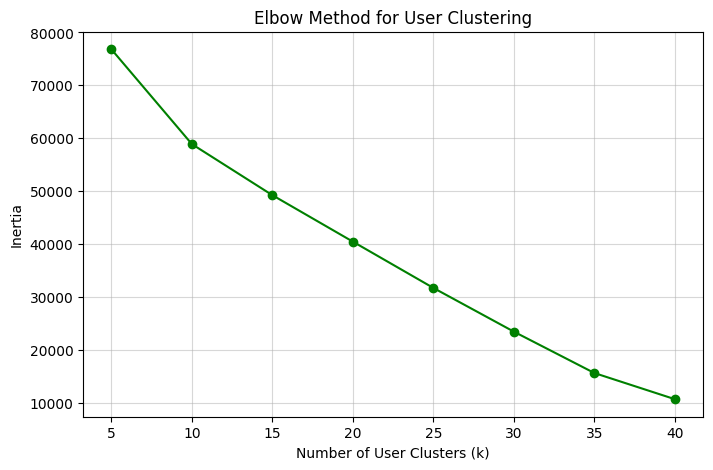


Running final user clustering with k=15...
✅ Users clustered into 15 segments.

--- User Cluster Distribution ---
              count
user_cluster       
0             19558
1              7015
2              3853
3              4877
4              4834
5              3303
6              2115
7              8235
8              3086
9              1817
10            30810
11             2441
12             2814
13             1918
14             1510

--- Analyzing User Cluster Taste Profiles ---

--- User Cluster 0 ---
Top 3 interests are in Product Buckets:
  - Bucket 44 (Avg: 0.11 items) -> [jacket, zipper, coat, pockets, fleece]
  - Bucket 28 (Avg: 0.11 items) -> [pants, pockets, waist, drawstring, elastic]
  - Bucket 41 (Avg: 0.10 items) -> [running, shoe, cushioning, asics, rubber]

--- User Cluster 1 ---
Top 3 interests are in Product Buckets:
  - Bucket 0 (Avg: 1.00 items) -> [scarf, mask, black, size, face]
  - Bucket 1 (Avg: 0.00 items) -> [wash, cotton, polyester, machine, c

In [13]:
# ============================================================
# STAGE 2: USER CLUSTERING BASED ON PRODUCT BUCKETS
# ============================================================

# --- 1. Link Product Clusters to Reviews ---
# We need to know which product cluster each reviewed item belongs to.
# The 'meta_df_copy' has the parent_asin and the product_cluster.
# The 'reviews_df' has the user_id and the parent_asin.

print("Linking users to the product clusters they reviewed...")

# Merge the review data with our newly clustered product metadata
user_product_clusters_df = pd.merge(
    reviews_df[['user_id', 'parent_asin']],
    meta_df_copy[['parent_asin', 'product_cluster']],
    on='parent_asin',
    how='inner'
)

print(f"✅ Merge complete. Total interactions: {len(user_product_clusters_df)}")

# --- 2. Create User Taste Profiles from Product Buckets ---
# For each user, count how many items they reviewed from each product bucket.
print("\nCreating user taste profiles based on product buckets...")

user_taste_profiles = user_product_clusters_df.groupby(
    ['user_id', 'product_cluster']
).size().unstack(fill_value=0)

print(f"✅ User taste profiles created with shape: {user_taste_profiles.shape}")
print(f"(Users: {user_taste_profiles.shape[0]}, Product Buckets: {user_taste_profiles.shape[1]})")

# --- 3. Cluster the Users ---
print("\nClustering users based on their taste profiles...")

# Elbow method to find a good k for user clustering
user_inertias = []
user_k_range = range(5, 41, 5)  # Test k from 5 to 40

for k in user_k_range:
    user_kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    user_kmeans.fit(user_taste_profiles)
    user_inertias.append(user_kmeans.inertia_)
    print(f"  k={k}, inertia={user_kmeans.inertia_:.2f}")

# Plot the elbow curve for user clustering
plt.figure(figsize=(8, 5))
plt.plot(user_k_range, user_inertias, 'go-')
plt.xlabel('Number of User Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for User Clustering')
plt.grid(True, alpha=0.5)
plt.show()

# --- 4. Perform Final User Clustering and Analysis ---
best_k_users = 15  # Adjust based on elbow curve
print(f"\nRunning final user clustering with k={best_k_users}...")

final_user_kmeans = KMeans(n_clusters=best_k_users, random_state=42, n_init=10)
user_taste_profiles['user_cluster'] = final_user_kmeans.fit_predict(user_taste_profiles)

print(f"✅ Users clustered into {best_k_users} segments.")
print("\n--- User Cluster Distribution ---")
print(user_taste_profiles['user_cluster'].value_counts().sort_index().to_frame())

# --- 5. "Test" the Clusters by Analyzing Them ---
print("\n--- Analyzing User Cluster Taste Profiles ---")

# The centroids represent the "average user" in each cluster.
user_centroids_df = pd.DataFrame(
    final_user_kmeans.cluster_centers_,
    columns=user_taste_profiles.columns[:-1]  # Exclude the 'user_cluster' column itself
)

# For each user cluster, find the top 3 product buckets they are interested in.
for i in range(best_k_users):
    print(f"\n--- User Cluster {i} ---")
    
    centroid = user_centroids_df.iloc[i]
    
    # Find the product buckets with the highest average counts
    top_product_buckets = centroid.sort_values(ascending=False).head(3)
    
    print(f"Top 3 interests are in Product Buckets:")
    for bucket_id, avg_count in top_product_buckets.items():
        # Get the keywords for this product bucket to make it interpretable
        keywords = ', '.join(terms[ind] for ind in order_centroids[bucket_id, :5])
        print(f"  - Bucket {bucket_id} (Avg: {avg_count:.2f} items) -> [{keywords}]")


--- Analyzing cohesiveness of all user clusters ---

--- Analysis for User Cluster 0 (19558 users) ---
  Average distance to centroid: 0.96
  Standard Deviation of dist:   0.05
  Max distance in cluster:      2.74

--- Analysis for User Cluster 1 (7015 users) ---
  Average distance to centroid: 0.03
  Standard Deviation of dist:   0.19
  Max distance in cluster:      5.38

--- Analysis for User Cluster 2 (3853 users) ---
  Average distance to centroid: 0.05
  Standard Deviation of dist:   0.23
  Max distance in cluster:      5.99

--- Analysis for User Cluster 3 (4877 users) ---
  Average distance to centroid: 0.02
  Standard Deviation of dist:   0.12
  Max distance in cluster:      2.00

--- Analysis for User Cluster 4 (4834 users) ---
  Average distance to centroid: 0.03
  Standard Deviation of dist:   0.17
  Max distance in cluster:      5.47

--- Analysis for User Cluster 5 (3303 users) ---
  Average distance to centroid: 0.05
  Standard Deviation of dist:   0.23
  Max distance in 

/tmp/ipykernel_355725/1305363390.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='distance', data=distance_df, palette='viridis')


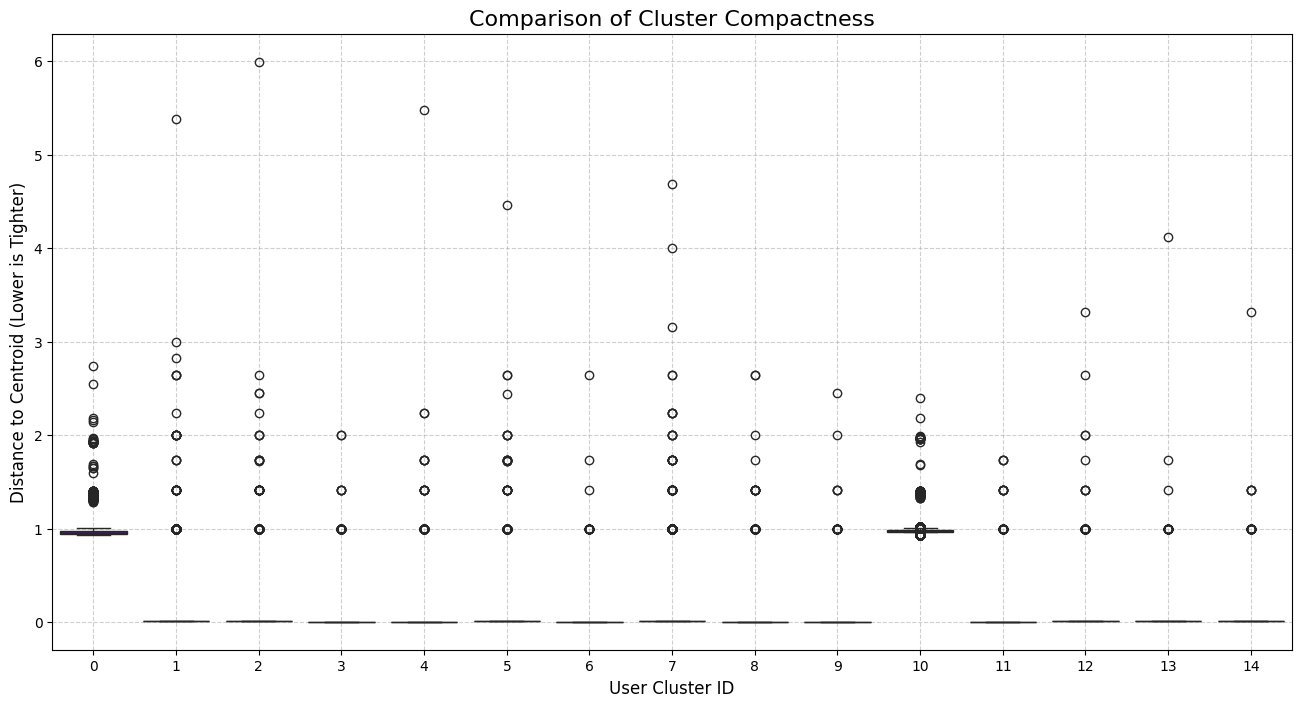

In [14]:
# ============================================================
# STAGE 3: INTERROGATE ALL CLUSTERS
# ============================================================
from scipy.spatial import distance
import numpy as np
import seaborn as sns

# --- 1. Loop Through Each Cluster to Calculate Distances ---
print("--- Analyzing cohesiveness of all user clusters ---")

# This list will store the distances for each cluster, for plotting
distance_data = []

for i in range(best_k_users):  # best_k_users was set to 15 previously
    
    # Isolate data for the current cluster
    cluster_members = user_taste_profiles[user_taste_profiles['user_cluster'] == i].drop('user_cluster', axis=1)
    
    if not cluster_members.empty:
        # Get the centroid for this cluster
        cluster_centroid = final_user_kmeans.cluster_centers_[i]

        # Calculate the distance for each member to the centroid
        distances = distance.cdist(cluster_members, [cluster_centroid], 'euclidean').flatten()
        
        # Store the results in a format suitable for plotting
        for d in distances:
            distance_data.append({'cluster': i, 'distance': d})

        # --- 2. Print Statistics for the Current Cluster ---
        print(f"\n--- Analysis for User Cluster {i} ({len(cluster_members)} users) ---")
        print(f"  Average distance to centroid: {np.mean(distances):.2f}")
        print(f"  Standard Deviation of dist:   {np.std(distances):.2f}")
        print(f"  Max distance in cluster:      {np.max(distances):.2f}")

# --- 3. Create a Boxplot for Visual Comparison ---
if distance_data:
    distance_df = pd.DataFrame(distance_data)

    plt.figure(figsize=(16, 8))
    sns.boxplot(x='cluster', y='distance', data=distance_df, palette='viridis')
    
    plt.title("Comparison of Cluster Compactness", fontsize=16)
    plt.xlabel("User Cluster ID", fontsize=12)
    plt.ylabel("Distance to Centroid (Lower is Tighter)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Could not generate distance data for plotting.")


In [15]:
# ============================================================
# STAGE 4: HIERARCHICAL CLUSTERING - BREAKING DOWN LARGE CLUSTERS
# ============================================================

# Define which clusters we want to investigate further
clusters_to_break_down = [0, 10]
# Define how many sub-clusters to look for in each
num_sub_clusters = 5 

for cluster_id in clusters_to_break_down:
    print("\n" + "="*80)
    print(f"INVESTIGATING AND SUB-CLUSTERING USER CLUSTER {cluster_id}")
    print("="*80)
    
    # --- 1. Isolate the data for the large cluster ---
    parent_cluster_data = user_taste_profiles[user_taste_profiles['user_cluster'] == cluster_id].drop('user_cluster', axis=1)
    
    if parent_cluster_data.empty:
        print(f"Cluster {cluster_id} is empty. Skipping.")
        continue
        
    print(f"Found {len(parent_cluster_data)} users to sub-cluster.")

    # --- 2. Run a new K-Means on this subset ---
    print(f"\nRunning K-Means to find {num_sub_clusters} sub-clusters...")
    
    sub_kmeans = KMeans(n_clusters=num_sub_clusters, random_state=42, n_init=10)
    parent_cluster_data['sub_cluster'] = sub_kmeans.fit_predict(parent_cluster_data)
    
    print("✅ Sub-clustering complete.")
    print("\n--- Sub-Cluster Distribution ---")
    print(parent_cluster_data['sub_cluster'].value_counts().sort_index().to_frame())

    # --- 3. Analyze the new sub-clusters ---
    print("\n--- Analyzing Sub-Cluster Taste Profiles ---")
    
    sub_centroids_df = pd.DataFrame(
        sub_kmeans.cluster_centers_,
        columns=parent_cluster_data.columns[:-1]
    )

    for i in range(num_sub_clusters):
        # Get the average taste profile for this new sub-cluster
        centroid = sub_centroids_df.iloc[i]
        
        # Find the top product buckets that define this sub-cluster
        top_product_buckets = centroid.sort_values(ascending=False).head(3)
        
        print(f"\n--- Sub-Cluster {cluster_id}-{i} ---")
        print(f"Top 3 interests are in Product Buckets:")
        
        for bucket_id, avg_count in top_product_buckets.items():
            if avg_count > 0.01:  # Only show meaningful interests
                # Get the keywords for this product bucket to make it interpretable
                keywords = ', '.join(terms[ind] for ind in order_centroids[bucket_id, :5])
                print(f"  - Bucket {bucket_id} (Avg: {avg_count:.2f} items) -> [{keywords}]")



INVESTIGATING AND SUB-CLUSTERING USER CLUSTER 0
Found 19558 users to sub-cluster.

Running K-Means to find 5 sub-clusters...
✅ Sub-clustering complete.

--- Sub-Cluster Distribution ---
             count
sub_cluster       
0             2102
1            11871
2             1762
3             2116
4             1707

--- Analyzing Sub-Cluster Taste Profiles ---

--- Sub-Cluster 0-0 ---
Top 3 interests are in Product Buckets:
  - Bucket 28 (Avg: 1.00 items) -> [pants, pockets, waist, drawstring, elastic]

--- Sub-Cluster 0-1 ---
Top 3 interests are in Product Buckets:
  - Bucket 41 (Avg: 0.17 items) -> [running, shoe, cushioning, asics, rubber]
  - Bucket 11 (Avg: 0.15 items) -> [heel, approximately, measures, sole, platform]
  - Bucket 16 (Avg: 0.14 items) -> [necklace, pendant, chain, jewelry, gift]

--- Sub-Cluster 0-2 ---
Top 3 interests are in Product Buckets:
  - Bucket 20 (Avg: 1.00 items) -> [lens, sunglasses, polarized, frame, millimeters]

--- Sub-Cluster 0-3 ---
Top 3 inter

--- Analyzing cohesiveness of all new sub-clusters ---

--- Processing Parent Cluster 0 ---
  Sub-Cluster 0-0 (2102 users): Avg Dist = 0.02, Std Dev = 0.12
  Sub-Cluster 0-1 (11871 users): Avg Dist = 0.94, Std Dev = 0.06
  Sub-Cluster 0-2 (1762 users): Avg Dist = 0.01, Std Dev = 0.09
  Sub-Cluster 0-3 (2116 users): Avg Dist = 0.01, Std Dev = 0.12
  Sub-Cluster 0-4 (1707 users): Avg Dist = 0.01, Std Dev = 0.10

--- Processing Parent Cluster 10 ---
  Sub-Cluster 10-0 (1474 users): Avg Dist = 0.01, Std Dev = 0.11
  Sub-Cluster 10-1 (23954 users): Avg Dist = 0.97, Std Dev = 0.04
  Sub-Cluster 10-2 (1741 users): Avg Dist = 0.01, Std Dev = 0.07
  Sub-Cluster 10-3 (1853 users): Avg Dist = 0.01, Std Dev = 0.07
  Sub-Cluster 10-4 (1788 users): Avg Dist = 0.01, Std Dev = 0.08


/tmp/ipykernel_355725/857229183.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='distance', data=distance_df_sub, palette='muted')


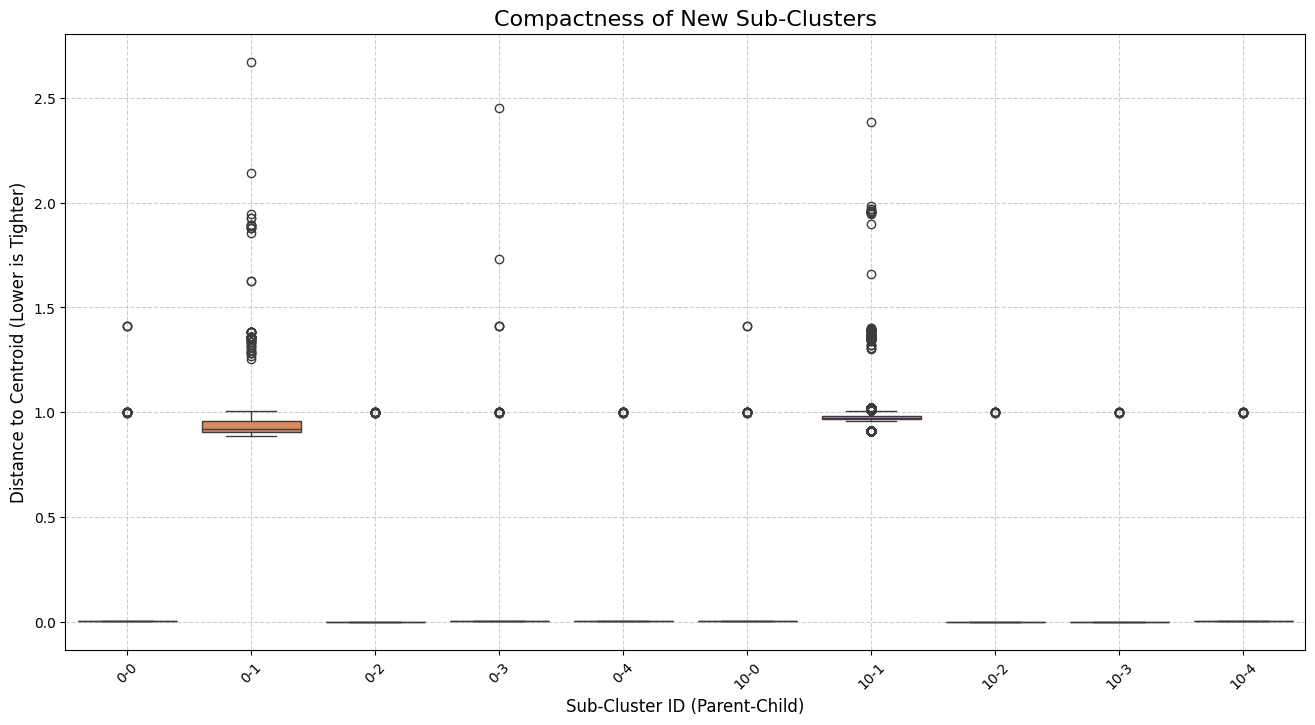

In [16]:
# ============================================================
# STAGE 5: COHESION ANALYSIS OF THE SUB-CLUSTERS
# ============================================================
from scipy.spatial import distance
import numpy as np
import seaborn as sns
import pandas as pd

print("--- Analyzing cohesiveness of all new sub-clusters ---")

# This list will store the distances for the final boxplot
distance_data_sub = []

# Define the clusters we broke down and how many sub-clusters we made
clusters_to_break_down = [0, 10]
num_sub_clusters = 5 

# Loop through each parent cluster that we previously broke down
for cluster_id in clusters_to_break_down:
    print(f"\n--- Processing Parent Cluster {cluster_id} ---")
    
    # Isolate the data for the parent cluster again
    parent_cluster_data = user_taste_profiles[user_taste_profiles['user_cluster'] == cluster_id].drop('user_cluster', axis=1)
    
    if parent_cluster_data.empty:
        print(f"Skipping Parent Cluster {cluster_id} as it is empty.")
        continue
        
    # We need to re-run the clustering for this subset to get the specific model and centroids
    sub_kmeans = KMeans(n_clusters=num_sub_clusters, random_state=42, n_init=10)
    sub_labels = sub_kmeans.fit_predict(parent_cluster_data)
    
    # Now, loop through each new sub-cluster
    for i in range(num_sub_clusters):
        
        # Get the original data points for all users in this sub-cluster
        sub_cluster_members = parent_cluster_data[sub_labels == i]
        
        if not sub_cluster_members.empty:
            # Get the centroid for this specific sub-cluster
            sub_cluster_centroid = sub_kmeans.cluster_centers_[i]

            # Calculate the distance of each member to the centroid
            distances = distance.cdist(sub_cluster_members, [sub_cluster_centroid], 'euclidean').flatten()
            
            # Store the results for our plot
            for d in distances:
                distance_data_sub.append({'cluster': f"{cluster_id}-{i}", 'distance': d})

            # Print the statistics for this sub-cluster
            print(f"  Sub-Cluster {cluster_id}-{i} ({len(sub_cluster_members)} users): "
                  f"Avg Dist = {np.mean(distances):.2f}, Std Dev = {np.std(distances):.2f}")
            
# --- Create the Boxplot for Visual Comparison ---
if distance_data_sub:
    distance_df_sub = pd.DataFrame(distance_data_sub)

    plt.figure(figsize=(16, 8))
    sns.boxplot(x='cluster', y='distance', data=distance_df_sub, palette='muted')
    
    plt.title("Compactness of New Sub-Clusters", fontsize=16)
    plt.xlabel("Sub-Cluster ID (Parent-Child)", fontsize=12)
    plt.ylabel("Distance to Centroid (Lower is Tighter)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("\nCould not generate distance data for plotting.")


In [ ]:
# ==============================================================================
# CELL 4: Analysis and Visualization
# ==============================================================================

# Plot clustering evaluation metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Silhouette scores
axes[0].plot(k_range, silhouette_scores, 'bo-')
axes[0].axvline(x=best_k, color='r', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Analysis')
axes[0].grid(True, alpha=0.3)

# Inertia (Elbow method)
axes[1].plot(k_range, inertias, 'go-')
axes[1].axvline(x=best_k, color='r', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Elbow Method')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze cluster centroids (taste profiles)
print("\n" + "="*60)
print("CLUSTER TASTE PROFILES")
print("="*60)

centroids_df = pd.DataFrame(
    final_kmeans.cluster_centers_,
    columns=user_taste_df.columns[:-1],  # exclude 'cluster' column
    index=[f'Cluster {i}' for i in range(best_k)]
)

# Show top categories for each cluster
for i in range(best_k):
    print(f"\n--- Cluster {i} (n={sum(cluster_labels == i)} users) ---")
    cluster_profile = centroids_df.iloc[i].sort_values(ascending=False)
    top_categories = cluster_profile.head(10)
    
    print("Top categories:")
    for category, score in top_categories.items():
        if score > 0.1:  # Only show meaningful scores
            print(f"  {category}: {score:.3f}")

# PCA visualization
print(f"\nCreating 2D visualization...")
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('User Clusters - Taste-Based Segmentation\n(PCA 2D Projection)')
plt.colorbar(scatter, label='Cluster')

# Add cluster centers
pca_centers = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"✅ Analysis complete! Users segmented into {best_k} taste-based clusters.")
print(f"Total variance explained by first 2 PCs: {sum(pca.explained_variance_ratio_):.1%}")